<a href="https://colab.research.google.com/github/shubham13596/Stanford-CS224S/blob/main/CS224S_HW3_Warm_Up_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CS224S Assignment 3 Warm Up
##HarperValleyBank Data Exploration & CTC Implementation


This notebook is worth 60 points out of the total 160 points for Homework 3. Don't forget to work on the neural network training Colab after this one! See the assignment handout on the course website for submission instructions.

## Setup for Google Drive and Required Libraries

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files.

You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)


DRIVE_PATH = '/content/gdrive/MyDrive/cs224s_spring2025'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/cs224s_spring2025'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

if not os.path.isdir(DRIVE_PATH):
    raise FileNotFoundError(f"Cannot find folder at {DRIVE_PATH}")

SYM_PATH = '/content/HW3_data'

if os.path.lexists(SYM_PATH):
    os.remove(SYM_PATH)

os.symlink(DRIVE_PATH, SYM_PATH)
print(f"Linked {SYM_PATH} →")
print(f"       {os.readlink(SYM_PATH)}")


Mounted at /content/gdrive
Linked /content/HW3_data →
       /content/gdrive/MyDrive/cs224s_spring2025


In [2]:
#@title Download HarperValleyBank dataset
#@markdown It takes ~10 minutes to download the dataset. You only need to do this once!

DATA_PATH = '{}/data'.format(SYM_PATH)
if not os.path.exists(DATA_PATH):
  %mkdir $DATA_PATH
%cd $DATA_PATH
if not os.path.exists(os.path.join(DATA_PATH, 'harpervalleybank')):
  !wget -q http://web.stanford.edu/class/cs224s/download/harpervalleybank.zip
  !unzip -q harpervalleybank.zip
  %rm harpervalleybank.zip

/content/gdrive/MyDrive/cs224s_spring2025/data


In [7]:
#@title Import packages
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import json
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from typing import Tuple
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Part 1:  HarperValleyBank Dataset Exploration

Let's first explore the [HarperValleyBank](https://arxiv.org/abs/2010.13929) dataset! The dataset primarily consists of simulated telephone/app-based consumer to banker interactions. For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system.






## Getting Corpus Statistics

The structure of the HarperValleyBank dataset is:
```
data
    audio
        agent
            <sid1>.wav
            <sid2>.wav
            ...
        caller
            <sid1>.wav
            <sid2>.wav
            ...
    metadata
        <sid1>.json
        <sid2>.json
        ...
    transcript
        <sid1>.json
        <sid2>.json
        ...
```
Every consumer-banker conversation has an id referred to as `sid ` .  All associated files are named based on that sid.

For every conversation, there are four files:

- Two single-channel audio files
- One transcript file
- One metadata file

The audio files are stored separately under the audio/agent and audio/caller directories.


##### <ins>**Task 1.1.1**</ins>: **Number of conversations** **(2 points)**

Fill in the function number_of_conversations to compute the total number of conversations in the dataset.

(Hint: this can be done in just one line of code)


In [6]:

BASE = os.path.join(SYM_PATH, 'data', 'harpervalleybank')

agent_audio_path  = os.path.join(BASE, 'audio')           # contains 'agent/' & 'caller/'
caller_audio_path = os.path.join(BASE, 'audio', 'caller')
transcript_path   = os.path.join(BASE, 'transcript')
metadata_path     = os.path.join(BASE, 'metadata')

def number_of_conversations(path: str) -> int:
  """Gets number of conversations in the dataset.

  Args:
    path: Path to relevant directory.

  Returns:
    Number of conversations.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  return len([name for name in os.listdir(path)])

  ############################

path = transcript_path
print('Number of conversations: ' + str(number_of_conversations(path)))

Number of conversations: 1446


##### <ins>**Task 1.1</ins>: Plot call duration (5 points)**

- Fill out the function `recording_time` to get the duration of recording in seconds and
- Plot a histogram with duration of recording (in seconds) as x-axis and count of conversations as y-axis. You can use `wavfile.read()` method.

For a single conversation, there are two audio files: `caller` and `agent` audio files. Both audio files for the same conversation have the same duration of recording because the other person's voice is replaced with silence. Thus, you can choose either caller or agent directory to get the total duration or recording.


Duration of recordings in seconds: 170318.28000000014


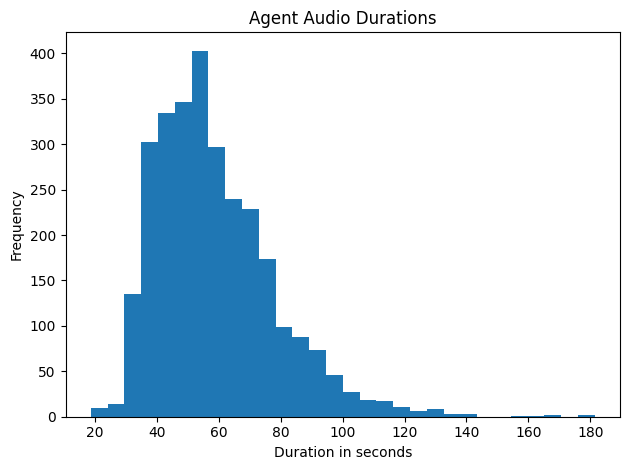

In [8]:
def recording_time(path_dir: str) -> Tuple[float, np.ndarray]:
    """Gets duration of recording
    Args:
        path_dir: Path to relevant directory.

    Returns:
        Duration of total recording in seconds (float),
        Numpy array of duration of recording for all conversations
    """
    total_duration, durations = 0.0, []

    # scan each entry in path_dir
    for entry in os.listdir(path_dir):
        entry_path = os.path.join(path_dir, entry)

        # if this is a subfolder, look inside for .wav files
        if os.path.isdir(entry_path):
            for fname in os.listdir(entry_path):
                if not fname.lower().endswith('.wav'):
                    continue
                wav_path = os.path.join(entry_path, fname)
                sr, data = wavfile.read(wav_path)
                dur = data.shape[0] / float(sr)
                total_duration += dur
                durations.append(dur)

        # if a .wav file lives at the top level
        elif entry.lower().endswith('.wav'):
            sr, data = wavfile.read(entry_path)
            dur = data.shape[0] / float(sr)
            total_duration += dur
            durations.append(dur)

    return total_duration, np.array(durations)


# --- Usage ---

path_agent  = agent_audio_path
path_caller = caller_audio_path

print("Duration of recordings in seconds:", recording_time(path_agent)[0])

# Plot histogram: X - Duration of individual files, Y - Count of files
_, duration_all = recording_time(path_agent)
plt.hist(duration_all, bins=30)
plt.xlabel('Duration in seconds')
plt.ylabel('Frequency')
plt.title('Agent Audio Durations')
plt.tight_layout()
plt.show()


## Transcript Analysis

**Transcripts:** The transcript json files are lists of segments where each segment is a json object with the following schema:

```json
{
    "channel_index": 2,
    "dialog_acts": [
        "gridspace_greeting"
    ],
    "duration_ms": 2280,
    "emotion": {
        "neutral": 0.33766093850135803,
        "negative": 0.024230705574154854,
        "positive": 0.6381083130836487
    },
    "human_transcript": "hello this is harper valley national bank",
    "index": 1,
    "offset_ms": 5990,
    "speaker_role": "agent",
    "start_ms": 3990,
    "start_timestamp_ms": 1591056064136,
    "transcript": "hello this is harper valley national bank",
    "word_durations_ms": [
        330,
        150,
        120,
        330,
        270,
        420,
        330
    ],
    "word_offsets_ms": [
        0,
        660,
        810,
        930,
        1260,
        1530,
        1950
    ]
}
```
The fields we will closely analyze for inference are:

- **"human_transcript":** A human-corrected version of the machine generated "transcript".

- **"emotion":** A softmax distribution over three categories (positive, negative, neutral) outputted by the Gridspace's Emotion model. This indicates the emotional tone of the utterance.

- **"dialog_acts":** A list of dialog act tags assigned to the utterance, identifying the type of conversational move
  - There are 16 possible dialog actions
  - Multiple dialog acts can be assigned to a single utterance.
  - The 16 dialog acts are:
    “yes” response, greeting, response, data confirmation, procedure explanation, data question, closing, data communication, “bear with me” response, acknowledgement, data response, filler disfluency, thanks, open question, problem description, and other.



##### <ins>**Task 1.2**</ins>**: Transcript Statistics (5 points)**

Load all transcript json files using `json.load()` and fill out the function `transcript_statistics` to get the following statistics:
- Total number of utterances
- Mean number of agent utterances per conversation
- Mean number of caller utterances per conversation
- Total number of words: Keep in mind that "[", "]", "<", ">" aren't considered as words.
- Number of unique words

You can get the text of the audio file by looking at the **"human_transcript"** field for each transcript. You can use `word_tokenize` function from `nltk.tokenize`.  

In [9]:
import nltk
nltk.download('punkt_tab') # <— installs the tokenizer NLTK is trying to load

word_tokenize("I don't we'll what to say needn't")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['I', 'do', "n't", 'we', "'ll", 'what', 'to', 'say', 'need', "n't"]

In [19]:
import json

#utterances_in_conversation = []

def transcript_statistics(
    path_transcript: str) -> Tuple[int, float, float, int, int]:
  """Get transcript statistics.

  Args:
    path_transcript: Path to transcript directory.

  Returns:
    Total number of utterances, Mean number of agent utterances per conversation,
    Mean number of caller utterances per conversation, total number of words,
    Number of unique words
  """
  #############################
  #### YOUR CODE GOES HERE ####
  json_data = []

  # files is a list with all the json files in the transcript folder
  json_files = os.listdir(path_transcript)

  # each file is one conversation
  for json_file in json_files:
    file_path = os.path.join(path_transcript, json_file)
    # loading each conversation i.e. json file, which is a list of json objects
    with open(file_path, 'r') as file:
      data = json.load(file)
      json_data.append(data)
      #print(f"Successfully uploaded {file_path}")

  total_utterances = 0
  total_agent_utterances = 0
  total_caller_utterances = 0
  utterances_in_conversation = []
  words_in_conversation = []
  unique_words = set()

  for conversation in json_data:
    # each json object in the list of json objects is accessed

    for segment in conversation:
      words_in_conversation.append(segment["human_transcript"])
      if segment["speaker_role"] =='agent':
        total_agent_utterances += 1
      else:
        total_caller_utterances += 1

    utterances_in_conversation.append(total_agent_utterances + total_caller_utterances)

  total_utterances = total_agent_utterances + total_caller_utterances
  mean_agent_utterances = total_agent_utterances/len(json_files)
  mean_caller_utterances = total_caller_utterances/len(json_files)
  total_words = len(words_in_conversation)
  unique_words = len(set(words_in_conversation))

  stats = (total_utterances, mean_agent_utterances, mean_caller_utterances, total_words, unique_words)

  plt.hist(utterances_in_conversation, bins=30)
  plt.xlabel('Utterances')
  plt.ylabel('Frequency')
  plt.title('Distribution of utterances')
  plt.tight_layout()
  plt.show()

  return stats

  #############################

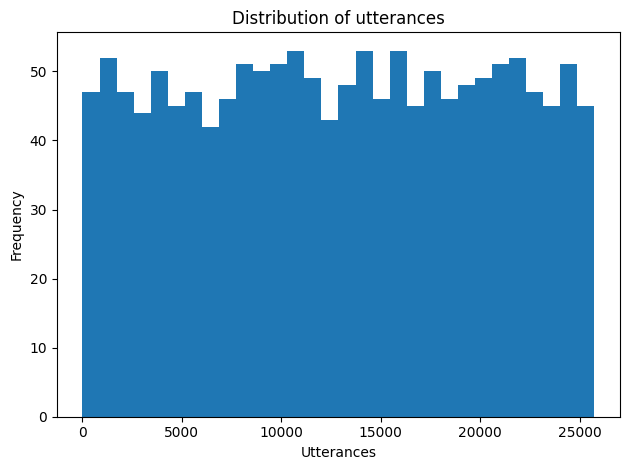

(25730, 9.195712309820193, 8.59820193637621, 25730, 7248)

In [20]:
a = transcript_statistics(transcript_path)
a

##### <ins>**Task 1.3**</ins>**: Distribution of Utterances (5 points)**

Plot the distribution of number of utterances per conversation and
And tell us the average number of utterances per conversation.

- `X`-axis: Number of utterances in a conversation

- `Y`-axis: Number of transcipts with that number of utterances

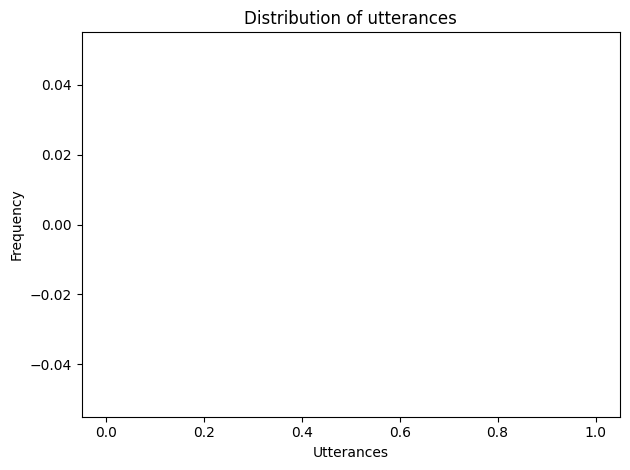

In [11]:
#############################
#### YOUR CODE GOES HERE ####
# Plot histogram: X - Utterances in individual conversation, Y - Count of utterances

plt.hist(utterances_in_conversation, bins=30)
plt.xlabel('Utterances')
plt.ylabel('Frequency')
plt.title('Distribution of utterances')
plt.tight_layout()
plt.show()

#############################

##### <ins>**Task 1.4**</ins>**: Distribution of Tasks (5 points)**

Plot a histogram of the distribution of tasks. Each metadata file describes the call center scenario for a conversation, and we will focus on the **tasks** field for this analysis. Hint: Each conversation has exactly one task.

**tasks:** field indicates the customer’s goal/intent in the conversation. There are 8 tasks: _order checks, check balance, replace card, reset password, get branch hours, pay bill, schedule appointment, and transfer money_. (`X`: Eight tasks, `Y`: Number of conversations)

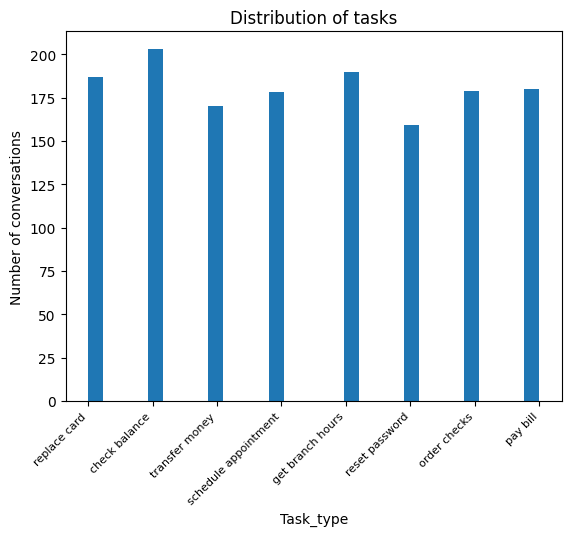

In [ ]:
task_names = ['order checks', 'check balance', 'replace card', 'reset password', 'get branch hours', 'pay bill', 'schedule appointment', 'transfer money']

#############################
#### YOUR CODE GOES HERE ####

metadata_files = os.listdir(metadata_path)
json_data = []
for file in metadata_files:
  file_path = os.path.join(metadata_path, file)
  with open(file_path, 'r') as file:
    data = json.load(file)
    json_data.append(data)


tasks = []
for conversation in json_data:
  # each json object in the list of json objects is accessed
  tasks.append(conversation["tasks"][0]["task_type"])

plt.hist(tasks, bins = 30)
plt.xlabel("Task_type")
plt.ylabel("Number of conversations")
plt.title("Distribution of tasks")
plt.xticks(rotation=45, ha='right', fontsize = 8)  # Rotate by 45 degrees and align text
plt.show()


#############################

##### <ins>**Task 1.5**</ins>**: Distribution of Dialog Actions (5 points)**

→ Plot a histogram showing the distribution of dialog actions across all utterances.

- Use the "dialog_acts" field from each transcript JSON file.
- Important: Each dialog act label begins with "gridspace_" (e.g., "gridspace_greeting").
  - For the plot, remove the "gridspace_" prefix and keep only the core action name (e.g., plot "greeting" instead of "gridspace_greeting").

- Plot Details:

 - X-axis: Dialog action classes (after removing "gridspace_").

 - Y-axis: Number of utterances for each dialog action.

→ What can you infer from the plot?

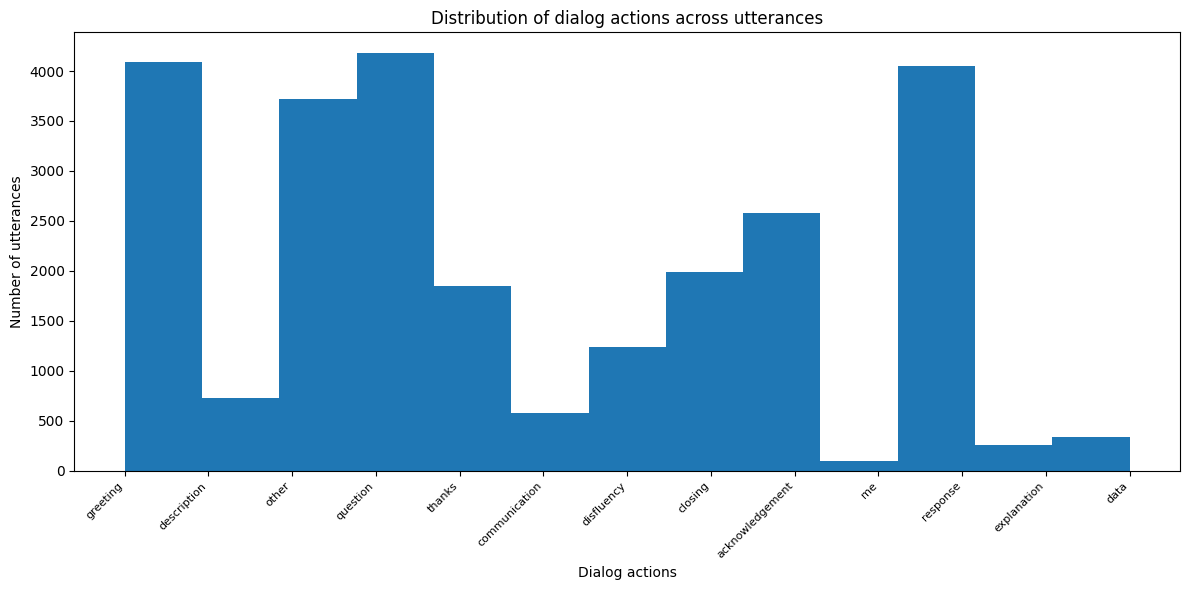

'\n{\n    "channel_index": 2,\n    "dialog_acts": [\n        "gridspace_greeting"\n    ],\n    "duration_ms": 2280,\n    "emotion": {\n        "neutral": 0.33766093850135803,\n        "negative": 0.024230705574154854,\n        "positive": 0.6381083130836487\n    },\n    "human_transcript": "hello this is harper valley national bank",\n    "index": 1,\n    "offset_ms": 5990,\n    "speaker_role": "agent",\n    "start_ms": 3990,\n    "start_timestamp_ms": 1591056064136,\n    "transcript": "hello this is harper valley national bank",\n    "word_durations_ms": [\n        330,\n        150,\n        120,\n        330,\n        270,\n        420,\n        330\n    ],\n    "word_offsets_ms": [\n        0,\n        660,\n        810,\n        930,\n        1260,\n        1530,\n        1950\n    ]\n}\n'

In [18]:
#############################
#### YOUR CODE GOES HERE ####


metadata_files = os.listdir(transcript_path)
json_data = []
for filename in metadata_files:  # Changed 'file' to 'filename'
    file_path = os.path.join(transcript_path, filename)
    with open(file_path, 'r') as file:
        data = json.load(file)
        json_data.append(data)

tasks = []
# Iterate through each conversation (which is a list of segments)
for conversation_segments in json_data:
    # Iterate through each segment within the conversation
    for segment in conversation_segments:
        # Check if 'dialog_acts' key exists and is not empty
        if "dialog_acts" in segment and segment["dialog_acts"]:
            # Assuming only the first dialog act is needed for the plot
            dialog_act = segment["dialog_acts"][0]
            # Remove the "gridspace_" prefix
            cleaned_act = dialog_act.split('_')[-1] # Use -1 in case of multiple underscores
            tasks.append(cleaned_act)

# For categorical data, let matplotlib choose appropriate bins
plt.figure(figsize=(12, 6))  # Make figure wider for better readability
# Use bar plot for clearer visualization of counts per category
plt.hist(tasks, bins=len(set(tasks))) # Still using hist, but specify bins for categorical data
plt.xlabel("Dialog actions")
plt.ylabel("Number of utterances") # Y-axis represents count of utterances, not conversations
plt.title("Distribution of dialog actions across utterances")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()  # Prevents label cutoff
plt.show()


"""
{
    "channel_index": 2,
    "dialog_acts": [
        "gridspace_greeting"
    ],
    "duration_ms": 2280,
    "emotion": {
        "neutral": 0.33766093850135803,
        "negative": 0.024230705574154854,
        "positive": 0.6381083130836487
    },
    "human_transcript": "hello this is harper valley national bank",
    "index": 1,
    "offset_ms": 5990,
    "speaker_role": "agent",
    "start_ms": 3990,
    "start_timestamp_ms": 1591056064136,
    "transcript": "hello this is harper valley national bank",
    "word_durations_ms": [
        330,
        150,
        120,
        330,
        270,
        420,
        330
    ],
    "word_offsets_ms": [
        0,
        660,
        810,
        930,
        1260,
        1530,
        1950
    ]
}
"""

#############################

##### <ins>**Task 1.6**</ins>**: Distribution of Emotions (5 points)**

→ Plot boxplots to visualize the distribution of emotion probabilities across all utterances.
- Use the "emotion" field from each transcript JSON file.
- Each utterance contains three emotion classes: neutral, positive, and negative, each associated with a probability (i.e., softmax output).
- For each emotion category, collect the probability scores across all utterances and plot a boxplot.
- Plot Details:
  - X-axis: Emotion classes (neutral, positive, negative)
  - Y-axis: Probability values for each class.

→ What can you infer from the plot?

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

# Part 2: Implementing CTC Loss

We introduce the Connectionist Temporal Classification (CTC) objective, which is a popular objective used to train neural networks to do speech recognition. Critically, it does not require you to know the alignments between inputs and outputs.

#### **Summary of CTC**

We highlight some of the main features of the CTC objective.

- Given a sequence of inputs `x_1, x_2, .., x_T`, an ASR model will map each of these to a probability of an alphabet of C tokens: `p_1, p_2, ..., p_T`. For example, if we are decoding to three possible characters, the probabilities for timestep `t` could look like `p_t = [0.3, 0.2, 0.5]`.

- We also have a sequence of symbol targets `y_1, y_2, ..., y_S` (note `S <= T`). Each `y_s` is a number from `0` to `C-1` (e.g. one of the characters).

- The main strategy is to decode each `x_t` to a predicted character `y'_t`. For example, `x_1, x_2, ..., x_6 -> c c a a a t`. This mapping is called an **alignment**. Then we can collapse repetitions to get `c a t` as the predicted output sequence. This simple strategy has some problems: how do you handle silences or repeated characters?

- CTC adds a special `blank` token. We'll call this `eps`. Now consider this example, `x_1, x_2, ..., x_12 -> h h e eps eps l l l eps l l o`. Now we can collapse everything in between each `eps` to get `h e eps l eps l o`. Removing blank tokens, we get the prediction `hello`.

- For an output sequence, there are many "valid" alignments. For example, given an input sequence `x_1, ..., x_6` and an output sequence `c a t`, valid alignments include `eps c c eps a t`, `c c a a t t`, or `c a eps eps eps t`. Example of invalid alignments include `c eps c eps a t`, `c c a a t` (too short if the input sequence has 6 tokens), and `c eps eps eps t t`.

- Let `A` represent all valid alignments of an output sequence to an input sequence. A simplified pseudocode for the CTC objective might look like:

```
all_log_prob = 0

for each (a_1, a_2, ..., a_S) in A:

    log_prob = 0

    for t in 1 to T:
        # The alignment a_s has a specific output character for input position t
        log_prob_t = log p(a_(s,t) | x_1, ..., x_T)
        # compute the joint probability by multiplying independent time steps
        # Adding in log space to avoid underflow
        log_prob += log_prob_t

    all_log_prob += log_prob
```
That is, the CTC loss computes the probability of all possible alignments. Please note that the pseudocode above is for intuition. In practice, it is often too slow to enumerate over `A` explicitly.

As an example, for an output sequence of length 50 (without any repeated characters) and an input sequence of length 100, the number of unique alignments is almost 10^40.

#### **Dynamic Programming in CTC**

In class, we introduced the "forward algorithm" to tractably compute likelihoods for HMMs. We can do something similar to score alignments more efficiently than manually enumerating over the full set.

In other words, we can do dynamic programming. Since many alignments share partial sub-sequences, we can  store the `log_prob` for all sub-sequences we have seen so far. This allows us to reuse computation when computing the likelihood for a new sequence.

The logic is as follows:

Recall `X` is the input sequence of maximum length `T` and `Y` is the output sequence of maximum length `S`. Build a new sequence `Z` that adds a blank token between every character.

```
Y = [y_1, y_2, ..., y_S]
Z = [eps, y_1, eps, y_2, ..., eps, y_S, eps]
  = [z_1, z_2, z_3, z_4, ..., z_2S-1, z_2S, z_2S+1]
```
Note that the length of `Z` is now `2S+1`.

**Step 1: Make a Cache.**

Instantiate a matrix of size `T x (2S+1)`. Call this matrix `C`. The index `C[t][s]` represents a probability score for the subsequence `z_1, ..., z_s` after observing `x_1, ..., x_t`. That is, `C[t][s] = p(y_1, ..., y_s/2 | x_1, ..., x_t)`.

**Step 2: Make an Update Rule.**

The goal of dynamic programming is to reuse `C[t-1]` in computing `C[t]`. To do that, we need to define an update rule. There are two cases depending on what  the token `z_s` is.

- <ins>Case 1</ins>: `z_s` is a blank token OR `z_s = z_s-2`. This is the standard forward algorithm update. We build `p(z_1, ..., z_s|x_1, ..., x_t)` using two parts: `p(z_1, ..., z_s|x_1, ..., x_t-1)` and `p(z_1, ..., z_s-1|x_1, ..., x_t-1)`. Assuming an increasing order of `t` and `s`, these two parts will already have been computed. (If `s = 0` you can ignore the `C[t-1][s-1]` term. If `t = 0`, set `C[t][s] = p(z_s | x_1, ..., x_t)`.)
```
C[t][s] = (C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```
In other words, `C[t-1][s-1]` and `C[t-1][s]` are known. The prediction for `p(z_s | x_1, ..., x_t)` is known (e.g. `log_probs`).

- <ins>Case 2</ins>: `z_s` is not a blank token AND `z_s != z_s-2`. The tricky part is to notice that `z_s-1` is a blank token. Since our Markov assumption says `y_t` should depend on `y_t-1`, which means `z_s` should depend on both `z_s-1` and `z_s-2` (since we artificially added `z_s-1`). Similarly, ignore terms that do not exist.
```
C[t][s] = (C[t-1][s-2] + C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```

Now, we still need two for loops to loop over `1 ... T` and `1 ... S` but this is usually much cheaper than looping over alignments.

```
C = init_cache(T, S)
for t in 1 to T:
  for s in 1 to 2S+1:
    C = do_update(t, s, C)

p_y_given_x = C[-1][-1] + C[-1][-2]  # sum the probability of the last epsilon and last non-epsilon tokens
```

For more information, refer to this [blog](https://distill.pub/2017/ctc/) or the original [paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf) by Alex Graves.



##### <ins>**Task 2.1**</ins>**: Implement CTC on your own and demonstrate your implementation [30 points]**

Please write the function in PyTorch that given a minibatch of model predicted probabilities and a minibatch of output sequences, computes the CTC objective.

**Note:** You cannot use the built-in `F.ctc_loss` in PyTorch. We will use this fast library for experiments in HW4.



In [ ]:
def ctc_loss(
    log_probs: torch.FloatTensor, targets: torch.LongTensor,
    input_lengths: torch.LongTensor, target_lengths: torch.LongTensor,
    blank: int = 0) -> torch.Tensor:
  """Connectionist Temporal Classification implementation.

  Args:
    log_probs: The log-beliefs returned by an ASR model.
      This is `log p(a_t | x_1, ..., x_T)`.
      (Shape: T x batch_size x C, where T is a maximum input sequence length and
      C is the alphabet size (including blank))

    targets: Sequence of contiguous output labels (no blanks).
      This is `y_1, ..., y_S`.
      (Shape: batch_size x S, where S is a maximum output sequence length)

    input_lengths: Lengths of each example in minibatch (<= T).
      (Shape: batch_size)

    target_lengths: Lengths of each target in minibatch (<= S).
      (Shape: batch_size)

    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)

  Returns:
    CTC loss averaged over minibatch.
  """
  #############################
  #### YOUR CODE GOES HERE ####

  batch_size = targets.shape[0]
  log_probs_reshaped = log_probs.permute(1, 0, 2)

  total_loss = 0.0

  for batch_idx in range(batch_size):
    input_length = input_lengths[batch_idx].item()
    target_length = target_lengths[batch_idx].item()
    target = targets[batch_idx, :target_length]
    log_probs_batch = log_probs_reshaped[batch_idx, :input_length]

    # Step 1: Make a Cache C of size T x (2S+1)
    C = torch.zeros((input_length, 2 * target_length + 1), device=log_probs.device)
    C.fill_(float('-inf'))  # Initialize with -inf (log(0))

    # Create Z sequence by adding blank token between every character
    z = torch.zeros(2 * target_length + 1, dtype=torch.long, device=log_probs.device)
    for i in range(target_length):
      z[2*i+1] = target[i]  # odd indices get target tokens
      # even indices remain 0 (blank)

    # Initialize first row (t=0)
    C[0, 0] = log_probs_batch[0, blank]  # probability of blank
    if target_length > 0:
      C[0, 1] = log_probs_batch[0, z[1]]  # probability of first character

    # Step 2: Apply the update rule using dynamic programming
    for t in range(1, input_length):
      for s in range(2 * target_length + 1):
        current_token = z[s].item()

        # Case 1: z_s is blank OR z_s = z_s-2
        if s == 0:  # special case for first position (can only come from blank)
          C[t, s] = C[t-1, s] + log_probs_batch[t, blank]
        elif current_token == blank or (s >= 2 and current_token == z[s-2].item()):
          # Add in log space (equivalent to multiply in probability space)
          prev_sum = torch.logsumexp(torch.stack([C[t-1, s], C[t-1, s-1]]), dim=0)
          C[t, s] = prev_sum + log_probs_batch[t, current_token]
        else:
          # Case 2: z_s is not blank AND z_s != z_s-2
          if s >= 2:
            prev_sum = torch.logsumexp(torch.stack([C[t-1, s], C[t-1, s-1], C[t-1, s-2]]), dim=0)
          else:
            prev_sum = torch.logsumexp(torch.stack([C[t-1, s], C[t-1, s-1]]), dim=0)
          C[t, s] = prev_sum + log_probs_batch[t, current_token]

    # Sum the probability of the last epsilon and last non-epsilon tokens
    if target_length == 0:
      batch_loss = -C[input_length-1, 0]
    else:
      batch_loss = -torch.logsumexp(torch.stack([C[input_length-1, 2*target_length],
                                               C[input_length-1, 2*target_length-1]]), dim=0)

    total_loss += batch_loss

  # Return average loss over minibatch
  return total_loss / batch_size
  #############################


  #############################


Here is a good sanity check. Test you code by checking below that `test` and `soln` are roughly equal. It's okay if your solution is much slower since the Pytorch one is coded in C. However, we will deduct points if you enumerate over all alignments as this is too slow for practical use.



In [ ]:
import torch
import torch.nn.functional as F

log_probs = torch.randn(50, 16, 20).log_softmax(2).detach().requires_grad_()
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)
input_lengths = torch.full((16,), 50, dtype=torch.long)
target_lengths = torch.randint(10,30,(16,), dtype=torch.long)

est = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0)
soln = torch.mean(F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='none'))

print(est.detach().numpy(), soln.detach().numpy())

116.25522 116.25522


The below code tests your loss function using log_probs and targets we provide. We load the test minibatches by calling `get_test_minibatches()`.


In [ ]:
import torch
import torch.nn.functional as F
import random

def get_test_minibatches() -> list:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs, targets, input_lengths, target_lengths
  """
  torch.manual_seed(224)
  np.random.seed(224)
  random.seed(224)

  T = np.array([])
  C = np.array([])
  N = np.array([])
  S = 40  # Target sequence length of longest target in batch (padding length)
  for i in range(10):
    T = np.append(T, random.randint(i+50, i+80))
    C = np.append(C, random.randint(int(0.4* T[i]), int(0.8*T[i])))
    N = np.append(N, random.randint(int(0.7 *C[i]), int(0.9*C[i])))

  log_probs = []
  input_lengths = []
  target_lengths = [] # 10 x N[i]
  targets = []
  for i in range(10):
    log_probs.append(torch.randn(int(T[i]), int(N[i]), int(C[i])).log_softmax(2).detach().requires_grad_())
    input_lengths.append(torch.full((int(N[i]),), fill_value = int(T[i]), dtype=torch.long))
    target_lengths.append(torch.randint(low = 1,high = S, size = (int(N[i]),), dtype=torch.long))
    targets.append(torch.randint(low = 1, high = int(C[i]), size = (int(N[i]), S), dtype=torch.long))

  return log_probs, targets, input_lengths, target_lengths

In [ ]:
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()

In [ ]:
%pip install -U ipytest

In [ ]:
import ipytest

ipytest.autoconfig()

### Testing CTC Loss

This test checks your custom `ctc_loss` implementation against the PyTorch reference `F.ctc_loss`.

It includes **two checks** for each sample:
- **Required Check:** Your loss must match the reference within a loose threshold of ±4.  
- **Optional Extra Credit Check:** Your loss must match the reference within a tighter threshold of ±0.1.  

In [ ]:
%%ipytest

def test_ctc_loss():
    """Required test: student loss should be close within 4."""
    with torch.no_grad(): # Added to disable gradients here so no backward pass is accidentally traced.
      for i in range(len(log_probs)):
          student_loss = ctc_loss(
              log_probs[i], targets[i], input_lengths[i], target_lengths[i], blank=0
          ).detach().cpu().numpy()

          reference_loss = F.ctc_loss(
              log_probs[i], targets[i], input_lengths[i], target_lengths[i],
              blank=0, reduction='none'
          ).detach().cpu().numpy().mean()

          # Required case
          assert abs(student_loss - reference_loss) < 4, \
              f"[Required test case failed] Sample {i}: student_loss={student_loss}, reference_loss={reference_loss}"

def test_ctc_loss_optional():
    """Optional extra credit test: student loss should be extremely close within 0.1."""
    with torch.no_grad(): # Added to disable gradients here so no backward pass is accidentally traced.
      for i in range(len(log_probs)):
          student_loss = ctc_loss(
              log_probs[i], targets[i], input_lengths[i], target_lengths[i], blank=0
          ).detach().cpu().numpy()

          reference_loss = F.ctc_loss(
              log_probs[i], targets[i], input_lengths[i], target_lengths[i],
              blank=0, reduction='none'
          ).detach().cpu().numpy().mean()

          # Optional Extra credit case
          assert abs(student_loss - reference_loss) < 0.1, \
              f"[Optional Extra credit test case failed] Sample {i}: student_loss={student_loss}, reference_loss={reference_loss}"

..                                                                                           [100%]
2 passed in 171.23s (0:02:51)


This is the end of Part 1 & 2. Great work!